# OCR - prepoznavanje karaktera sa digitalne slike

In [205]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
import random
import time
import math
from scipy import ndimage
from skimage.io import imread

## Pripreima obučavajućeg skupa

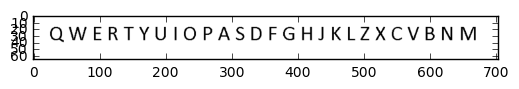

In [206]:
img = imread('images/font-1.png')
plt.imshow(img)

In [207]:
latters = ['Q', 'W', 'E', 'R', 'T', 'Y', 'U', 'I', 'O', 'P', 'A', 
           'S', 'D', 'F', 'G', 'H', 'J', 'K', 'L', 'Z', 'X', 'C', 'V', 'B', 'N', 'M']

labels = np.arange(0, len(latters))
print labels

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]


In [208]:
img0 = img[:, :, 0]

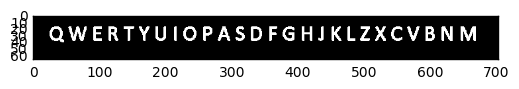

In [209]:
plt.imshow(img0<255, 'gray')

26


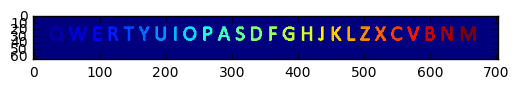

In [210]:
img_tr = img0<255
labeled, nr_objects = ndimage.label(img_tr)
print nr_objects
plt.imshow(labeled)

17 39


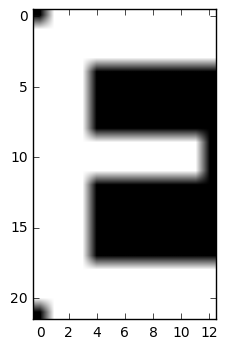

In [211]:
objects = ndimage.find_objects(labeled)
loc = objects[2]

plt.imshow(img_tr[loc], 'gray')
print loc[0].start, loc[0].stop


In [212]:
obj_img = 1.0*img_tr[loc]
(height, width) = obj_img.shape

17 39


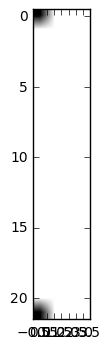

In [213]:
loc = ndimage.find_objects(labeled)[7]

plt.imshow(img_tr[loc], 'gray')
print loc[0].start, loc[0].stop


In [214]:
obj_img = 1.0*img_tr[loc]
(h, w) = obj_img.shape

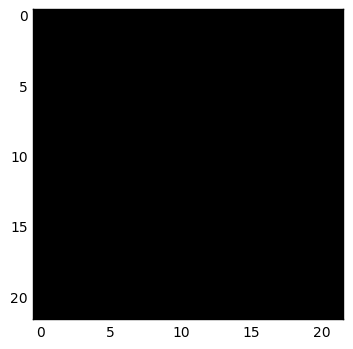

In [215]:
hw = max(w, h)
res2 = np.zeros((hw, hw), np.uint8)

plt.imshow(res2, 'gray')

In [216]:
def obj_resize(obj_img):
    (h, w) = obj_img.shape
    hw = max(w, h)
    res2 = np.zeros((hw, hw), np.uint8)
    res2[(hw-h)/2:(hw+h)/2, (hw-w)/2:(hw+w)/2] = obj_img
    return cv2.resize(res2,(28, 28), interpolation = cv2.INTER_CUBIC)

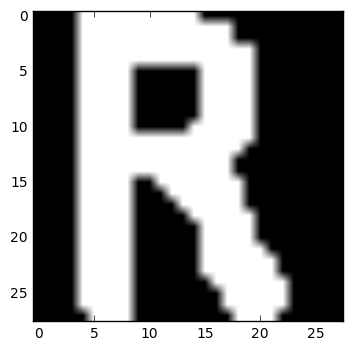

In [217]:
loc = objects[3]
img_obj = img_tr[loc]
img_obj = obj_resize(img_obj)
plt.imshow(img_obj, 'gray')

In [218]:
data = np.zeros((len(labels), 28*28), np.uint8)

In [219]:
data[0, :] = obj_resize(img_tr[objects[0]]).flatten()

In [220]:
for i in range(len(labels)):
    data[i, :] = obj_resize(img_tr[objects[i]]).flatten()

## Obučavajući skup pripremljen

data

latters

labels

# Neuronska mreža


In [221]:
def to_categorical(labels, n):
    retVal = np.zeros((len(labels), n), dtype='int')
    ll = np.array(list(enumerate(labels)))
    retVal[ll[:,0],ll[:,1]] = 1
    return retVal

test = [3, 5, 9]
print to_categorical(test, len(latters))

[[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [222]:
train_out = to_categorical(labels, len(latters))
train_data = data

In [223]:
#--------------- ANN ------------------
from keras.models import Sequential
from keras.layers.core import Activation, Dense
from keras.optimizers import SGD

In [224]:
# prepare model
model = Sequential()
model.add(Dense(50, input_dim=784))
model.add(Activation('relu'))
#model.add(Dense(10))
#model.add(Activation('sigmoid'))
model.add(Dense(len(latters)))
model.add(Activation('softmax'))

In [225]:
sgd = SGD(lr=0.1, decay=0.00001, momentum=0.7)
model.compile(loss='mean_squared_error', optimizer=sgd)

In [226]:
print train_data.shape
print train_out.shape


(26, 784)
(26, 26)


In [227]:
training = model.fit(train_data, train_out, nb_epoch=5000, batch_size=20, verbose=0)
print training.history['loss'][-1]

1.89907197217e-05


## Kako ovo da koristimo?

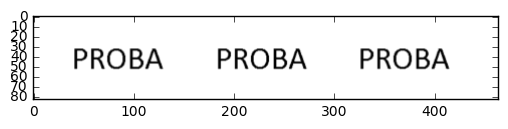

In [228]:
img = imread('images/test-3.png')

plt.imshow(img)

Primeniti iste transformacije kao kod obučavanja

1. izdvojiti regione

15


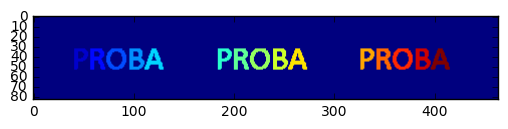

In [229]:
img_test = img[:,:,0]<255
labeled, nr_objects = ndimage.label(img_test)
print nr_objects
plt.imshow(labeled)

(slice(33L, 54L, None), slice(41L, 55L, None))


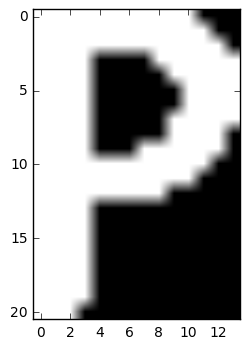

In [230]:
objects = ndimage.find_objects(labeled)

i = 0
loc = objects[i]
print loc
plt.imshow(img_test[loc], 'gray')

In [231]:
ch_test = obj_resize(img_test[objects[0]]).flatten()

In [251]:
test_data = []
for i in range(nr_objects):
    ch_test = obj_resize(img_test[objects[i]]).flatten()
    test_data.append(ch_test)
    t = model.predict(np.array([ch_test]), verbose=0)
    rez_t = t.argmax(axis=1)
    print latters[rez_t[0]]

P
R
O
B
A
P
R
O
B
A
P
R
O
B
A


### Kako prepoznati razmake?

Do sada je rađeno optičko prepoznavanje brojeva i matematičkih izraza. Kada je reč o čitanju stvarnog teksta, deo problema predstavlja i određivanje granica između reči i redova u tekstu. Kao rešenje moguće je koristiti K-means algoritam i klasifikovati razmak između regiona na dve grupe:
    * Razmak između slova u reči,
    * Razmak između reči"

In [238]:
for i in range(nr_objects):
    loc = objects[i]
    print "Xmin: ",loc[1].start," Xmax: ", loc[1].stop

Xmin:  41  Xmax:  55
Xmin:  57  Xmax:  72
Xmin:  73  Xmax:  93
Xmin:  96  Xmax:  111
Xmin:  111  Xmax:  130
Xmin:  184  Xmax:  198
Xmin:  200  Xmax:  215
Xmin:  216  Xmax:  236
Xmin:  239  Xmax:  254
Xmin:  254  Xmax:  273
Xmin:  326  Xmax:  340
Xmin:  342  Xmax:  357
Xmin:  358  Xmax:  378
Xmin:  381  Xmax:  396
Xmin:  396  Xmax:  415


In [241]:
region_distances = []
        
for i in range(1, nr_objects):
    curr = objects[i]
    prev = objects[i-1]
    region_distances.append(curr[1].start-prev[1].stop)

print region_distances

[2L, 1L, 3L, 0L, 54L, 2L, 1L, 3L, 0L, 53L, 2L, 1L, 3L, 0L]


### Obučimo KMeans klasifikator nad razmacima između karaktera

In [249]:
# k-means
from sklearn.cluster import KMeans
k_means_test = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)

print len(region_distances)
k_means_test.fit(np.array(region_distances).reshape(-1,1))

14


KMeans(copy_x=True, init='k-means++', max_iter=2000, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=1e-05,
    verbose=0)

In [257]:
# labels opisuje kom klasteru pripada svaki element
# 0 i 1 predstavljaju redni broj klastera
print k_means_test.labels_

[0 0 0 0 1 0 0 0 0 1 0 0 0 0]


In [263]:

def winner(output):
    return output.argmax(axis=0)
def display_result(outputs, alphabet, k_means):
    '''
    Funkcija određuje koja od grupa predstavlja razmak između reči, a koja između slova, i na osnovu
    toga formira string od elemenata pronađenih sa slike.
    Args:
        outputs: niz izlaza iz neuronske mreže.
        alphabet: niz karaktera koje je potrebno prepoznati
        kmeans: obučen kmeans objekat
    Return:
        Vraća formatiran string
    '''
    # Odrediti indeks grupe koja odgovara rastojanju između reči, pomoću vrednosti iz k_means.cluster_centers_
    # veća vrednost odgovara razmaku
    w_space_group = max(enumerate(k_means.cluster_centers_), key = lambda x: x[1])[0]
    #uzmemo prvi karakter direktno
    result = alphabet[winner(outputs[0])]
    for idx, output in enumerate(outputs[1:,:]):
        # Iterativno dodavati prepoznate elemente
        # Dodati space karakter u slučaju da odgovarajuće rastojanje između dva slova odgovara razmaku između reči.
        # U ovu svrhu, koristiti atribut niz k_means.labels_ koji sadrži sortirana rastojanja između susednih slova.
        if (k_means.labels_[idx] == w_space_group):
            result += ' '
        result += alphabet[winner(output)]
    return result

In [264]:
results_test = model.predict(np.array(test_data, np.float32))
print display_result(results_test, latters, k_means_test)

PROBA PROBA PROBA


### Kako prepoznati tekst u više redova?